In [1]:
import pandas as pd
from scapy.all import *
from scapy.utils import RawPcapReader
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP, TCP
import time
import numpy as np 
import binascii 
import seaborn as sns
import openpyxl
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline

In [2]:
file2 = rdpcap('7-data.pcap')
print(file2)

<03-13 los altos.pcap: TCP:12256 UDP:9869 ICMP:312 Other:4339>


In [3]:
file_name = file2

def display_param(n,ifile):
    ifile[n].display()
    return 0

print('Total Number of Packets is', len(file_name))
while(1):
    print('\nDo you want to continue?\n')
    c = input('Press c to continue or q to quit:')
    if(c == 'c'):
        p = int(input('\nEnter the packet whose details you want to display:'))
        display_param(p,file_name)
    if(c == 'q'):
        break

Total Number of Packets is 26776

Do you want to continue?

Press c to continue or q to quit:q


In [4]:
ethernet_frame = file_name[2]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload 

print(ethernet_frame.summary())
print(ip_packet.summary())
print(segment.summary())
print(data.summary()) 

Ether / IP / UDP 192.168.0.39:netbios_ns > 192.168.0.255:netbios_ns / NBNSQueryRequest
IP / UDP 192.168.0.39:netbios_ns > 192.168.0.255:netbios_ns / NBNSQueryRequest
UDP 192.168.0.39:netbios_ns > 192.168.0.255:netbios_ns / NBNSQueryRequest
NBNSQueryRequest


In [5]:
ethernet_frame

<Ether  dst=ff:ff:ff:ff:ff:ff src=00:50:56:24:55:6c type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=78 id=1380 flags= frag=0 ttl=128 proto=udp chksum=0xb2c4 src=192.168.0.39 dst=192.168.0.255 |<UDP  sport=netbios_ns dport=netbios_ns len=58 chksum=0x8088 |<NBNSQueryRequest  NAME_TRN_ID=39673 FLAGS=272 QDCOUNT=1 ANCOUNT=0 NSCOUNT=0 ARCOUNT=0 QUESTION_NAME='MK02962        ' SUFFIX=file server service NULL=0 QUESTION_TYPE=NB QUESTION_CLASS=INTERNET |>>>>

In [6]:
ip_packet

<IP  version=4 ihl=5 tos=0x0 len=78 id=1380 flags= frag=0 ttl=128 proto=udp chksum=0xb2c4 src=192.168.0.39 dst=192.168.0.255 |<UDP  sport=netbios_ns dport=netbios_ns len=58 chksum=0x8088 |<NBNSQueryRequest  NAME_TRN_ID=39673 FLAGS=272 QDCOUNT=1 ANCOUNT=0 NSCOUNT=0 ARCOUNT=0 QUESTION_NAME='MK02962        ' SUFFIX=file server service NULL=0 QUESTION_TYPE=NB QUESTION_CLASS=INTERNET |>>>

In [7]:
segment

<UDP  sport=netbios_ns dport=netbios_ns len=58 chksum=0x8088 |<NBNSQueryRequest  NAME_TRN_ID=39673 FLAGS=272 QDCOUNT=1 ANCOUNT=0 NSCOUNT=0 ARCOUNT=0 QUESTION_NAME='MK02962        ' SUFFIX=file server service NULL=0 QUESTION_TYPE=NB QUESTION_CLASS=INTERNET |>>

In [8]:
ether_fields = [field.name for field in Ether().fields_desc]
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]
arp_fields = [field.name for field in ARP().fields_desc]
icmp_fields = [field.name for field in ICMP().fields_desc]

In [9]:
tcp_col = ether_fields+ip_fields + ['time'] + tcp_fields

tcp_df = pd.DataFrame(columns=tcp_col)

print('Reading TCP/UDP packets......')
for packet in file_name[IP]:
    tcp_field_values = []
    tcp_field_values.append(packet.src)
    tcp_field_values.append(packet.dst)
    tcp_field_values.append(packet.type)
    for field in ip_fields:
        if field == 'options':
            tcp_field_values.append(len(packet[IP].fields[field]))
            #udp_field_values.append(len(packet[IP].fields[field]))
        else:
            tcp_field_values.append(packet[IP].fields[field])
            #udp_field_values.append(packet[IP].fields[field])
    
    tcp_field_values.append(packet.time)
    #udp_field_values.append(packet.time)
    
    ip_payload_type = type(packet[IP].payload)
    
    for field in tcp_fields:
        try:
            if field == 'options':
                tcp_field_values.append(len(packet[ip_payload_type].fields[field]))
            else:
                tcp_field_values.append(packet[ip_payload_type].fields[field])
        except:
            tcp_field_values.append(None)
                

    temp1_df = pd.DataFrame([tcp_field_values],columns = tcp_col)
    tcp_df = pd.concat([tcp_df,temp1_df],axis=0)
    
print('Reading Completed.')
tcp_df = tcp_df.reset_index()
tcp_df = tcp_df.drop(columns="index")

Reading TCP/UDP packets......
Reading Completed.


In [10]:
tcp_df.head()

,dst,src,type,version,ihl,tos,len,id,flags,frag,...,dport,seq,ack,dataofs,reserved,flags,window,chksum,urgptr,options
0,00:50:56:24:55:6c,01:00:5e:7f:ff:fa,2048,4,5,0,157,1368,,0,...,1900,None,None,None,None,None,None,50151,None,None
1,00:50:56:24:55:6c,ff:ff:ff:ff:ff:ff,2048,4,5,0,78,1380,,0,...,137,None,None,None,None,None,None,32904,None,None
2,00:50:56:24:55:6c,ff:ff:ff:ff:ff:ff,2048,4,5,0,202,1394,,0,...,138,None,None,None,None,None,None,61937,None,None
3,00:50:56:24:55:6c,ff:ff:ff:ff:ff:ff,2048,4,5,0,78,1395,,0,...,137,None,None,None,None,None,None,23411,None,None
4,00:50:56:24:55:6c,ff:ff:ff:ff:ff:ff,2048,4,5,0,78,1403,,0,...,137,None,None,None,None,None,None,23411,None,None


In [11]:
#Fetch ARP Data
arp_df = pd.DataFrame(columns=arp_fields)

print("Reading ARP Packets.....")
for packet in file_name[ARP]:
    field_values = []
    for field in arp_fields:
        field_values.append(packet[ARP].fields[field])
        
    df_append = pd.DataFrame([field_values], columns=arp_fields)
    arp_df = pd.concat([arp_df, df_append], axis=0)
print("Completed")

Reading ARP Packets.....
Completed


In [12]:
arp_df = arp_df.reset_index()
arp_df = arp_df.drop(columns="index")
arp_df.head()

,hwtype,ptype,hwlen,plen,op,hwsrc,psrc,hwdst,pdst
0,1,2048,6,4,1,00:1f:29:da:2d:79,192.168.1.104,00:00:00:00:00:00,192.168.1.1
1,1,2048,6,4,1,00:1f:29:da:2d:79,192.168.1.104,00:00:00:00:00:00,192.168.1.1
2,1,2048,6,4,1,00:1f:29:da:2d:79,192.168.1.104,00:00:00:00:00:00,192.168.1.1
3,1,2048,6,4,1,00:1f:29:da:2d:79,192.168.1.104,00:00:00:00:00:00,192.168.1.1
4,1,2048,6,4,1,00:1f:29:da:2d:79,192.168.1.104,00:00:00:00:00:00,192.168.1.1


In [13]:
#Fetch ICMP Data
field = icmp_fields[0:3]
icmp_df = pd.DataFrame(columns=field)
print("Reading ICMP Packets.....")
for packet in file_name[ICMP]:
    field_values = []
    field_values.append(packet.type)
    field_values.append(packet.code)
    field_values.append(packet.chksum)
        
    df_append = pd.DataFrame([field_values], columns=field)
    icmp_df = pd.concat([icmp_df, df_append], axis=0)
print("Completed")
icmp_df = icmp_df.reset_index()
icmp_df = icmp_df.drop(columns="index")
icmp_df.head()

Reading ICMP Packets.....
Completed


,type,code,chksum
0,2048,0,34537
1,2048,0,11053
2,2048,0,34535
3,2048,0,11051
4,2048,0,34430


In [14]:
writer = pd.ExcelWriter('Pcap_Data.xlsx', engine ='xlsxwriter')
tcp_df.to_excel(writer, sheet_name ='TCP_UDP') 
arp_df.to_excel(writer, sheet_name ='ARP')
icmp_df.to_excel(writer, sheet_name ='ICMP')
writer.save()

In [15]:
tcp_udp_df=pd.read_excel("Pcap_Data.xlsx",sheet_name="TCP_UDP")
arp_df=pd.read_excel("Pcap_Data.xlsx",sheet_name="ARP")
icmp_df=pd.read_excel("Pcap_Data.xlsx",sheet_name="ICMP")

In [16]:
tcp_udp_df.columns

Index(['Unnamed: 0', 'dst', 'src', 'type', 'version', 'ihl', 'tos', 'len',
       'id', 'flags', 'frag', 'ttl', 'proto', 'chksum', 'src.1', 'dst.1',
       'options', 'time', 'sport', 'dport', 'seq', 'ack', 'dataofs',
       'reserved', 'flags.1', 'window', 'chksum.1', 'urgptr', 'options.1'],
      dtype='object')

In [17]:
arp_df.columns

Index(['Unnamed: 0', 'hwtype', 'ptype', 'hwlen', 'plen', 'op', 'hwsrc', 'psrc',
       'hwdst', 'pdst'],
      dtype='object')

In [18]:
icmp_df.columns

Index(['Unnamed: 0', 'type', 'code', 'chksum'], dtype='object')

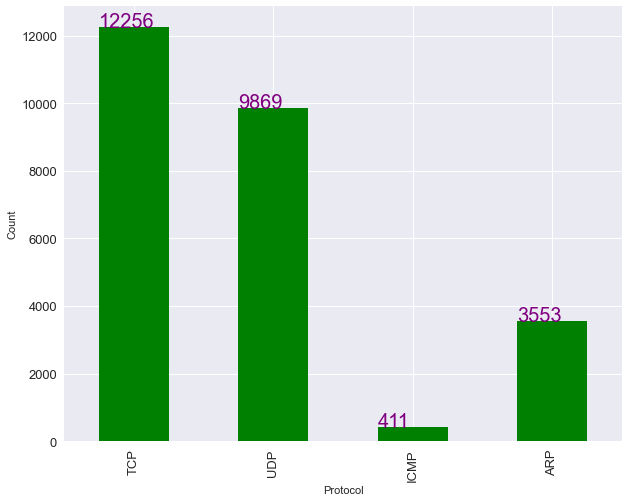

In [19]:
tcp_udp_val_cnt = tcp_udp_df['proto'].value_counts()
tcp_udp_val_cnt.index=['TCP','UDP','ICMP']
arp_icmp_val_cnt = pd.Series([len(arp_df)], index = ['ARP'])
proto_val_cnt = tcp_udp_val_cnt.append(arp_icmp_val_cnt)
#print(proto_val_cnt)

ax = proto_val_cnt.plot(kind='bar', figsize=(10,8),color="green", fontsize=13)
plt.xlabel('Protocol')
plt.ylabel('Count')


for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), i.get_height(), fontsize=20,color='purple')

In [20]:
tcp_udp_val_cnt

TCP     12256
UDP      9869
ICMP      411
Name: proto, dtype: int64

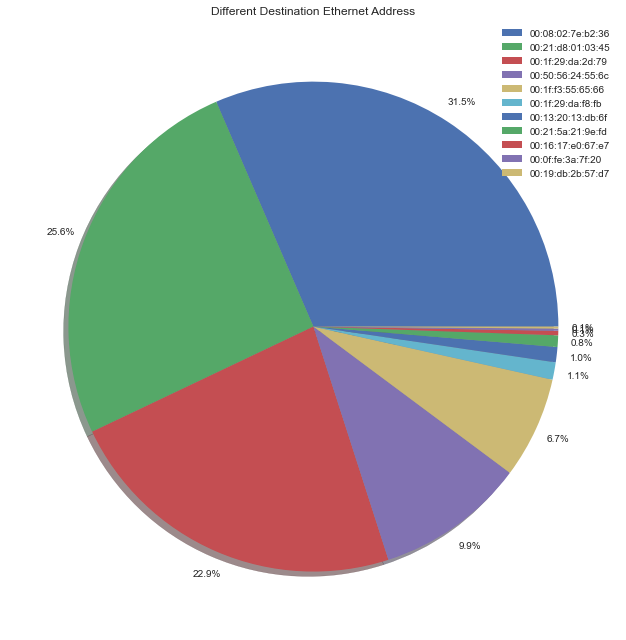

In [21]:
# Destination Ethernet Request in TCP_UDP
labels = list(tcp_udp_df['dst'].value_counts().keys())
fig, ax1 = plt.subplots(figsize = (20,9)) 
ax1.pie(tcp_udp_df['dst'].value_counts(), autopct='%.1f%%',shadow = True,pctdistance=1.1, labeldistance=1) 
plt.title("Different Destination Ethernet Address")
ax1.legend(labels, loc = "upper right") 
plt.tight_layout() 
plt.show()

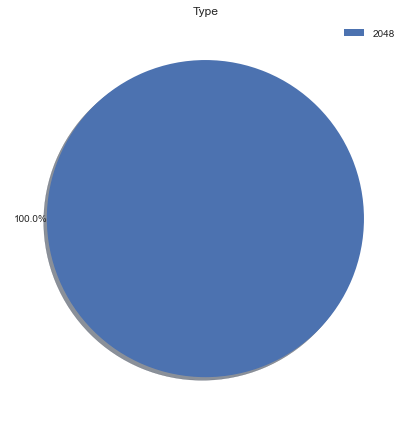

In [22]:
labels = list(tcp_udp_df['type'].value_counts().keys())
fig, ax1 = plt.subplots(figsize = (20,6)) 
ax1.pie(tcp_udp_df['type'].value_counts(), autopct='%.1f%%',shadow = True,pctdistance=1.1, labeldistance=1) 
plt.title("Type")
ax1.legend(labels, loc = "upper right") 
plt.tight_layout() 
plt.show()

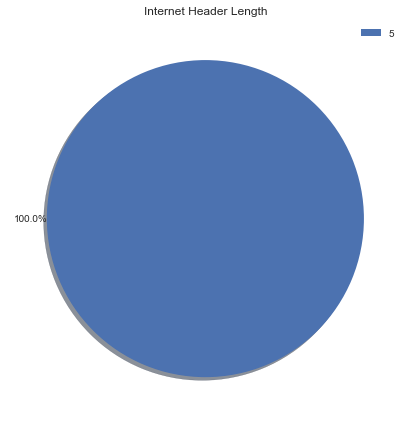

In [23]:
labels = list(tcp_udp_df['ihl'].value_counts().keys())
fig, ax1 = plt.subplots(figsize = (20,6)) 
ax1.pie(tcp_udp_df['ihl'].value_counts(), autopct='%.1f%%',shadow = True,pctdistance=1.1, labeldistance=1) 
plt.title("Internet Header Length")
ax1.legend(labels, loc = "upper right") 
plt.tight_layout() 
plt.show()

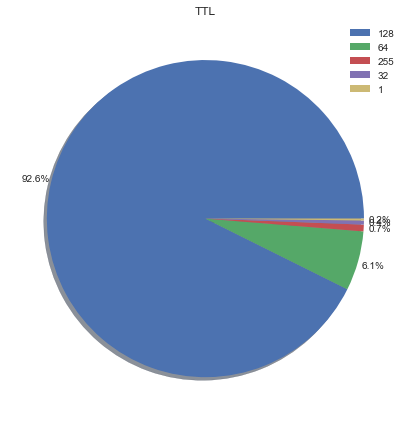

In [24]:
labels = list(tcp_udp_df['ttl'].value_counts().keys())
fig, ax1 = plt.subplots(figsize = (20,6)) 
ax1.pie(tcp_udp_df['ttl'].value_counts(), autopct='%.1f%%',shadow = True,pctdistance=1.1, labeldistance=1) 
plt.title("TTL")
ax1.legend(labels, loc = "upper right") 
plt.tight_layout() 
plt.show()

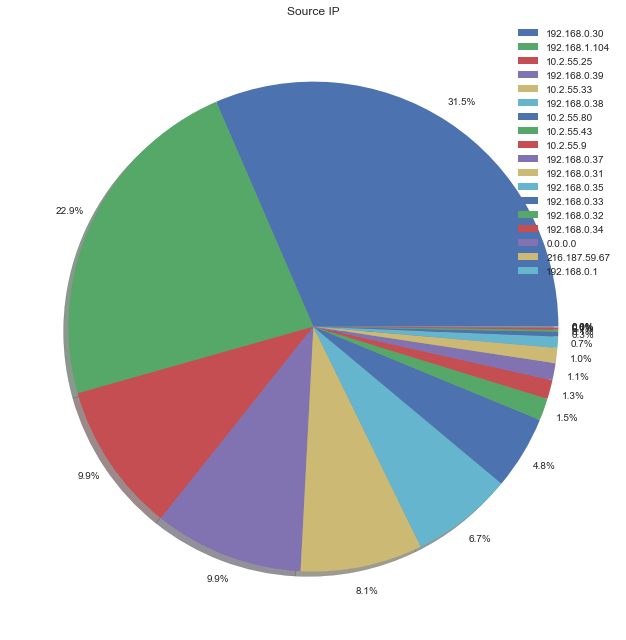

In [25]:
labels = list(tcp_udp_df['src.1'].value_counts().keys())
fig, ax1 = plt.subplots(figsize = (20,9)) 
ax1.pie(tcp_udp_df['src.1'].value_counts(), autopct='%.1f%%',shadow = True,pctdistance=1.1, labeldistance=1) 
plt.title("Source IP")
ax1.legend(labels, loc = "upper right") 
plt.tight_layout() 
plt.show()

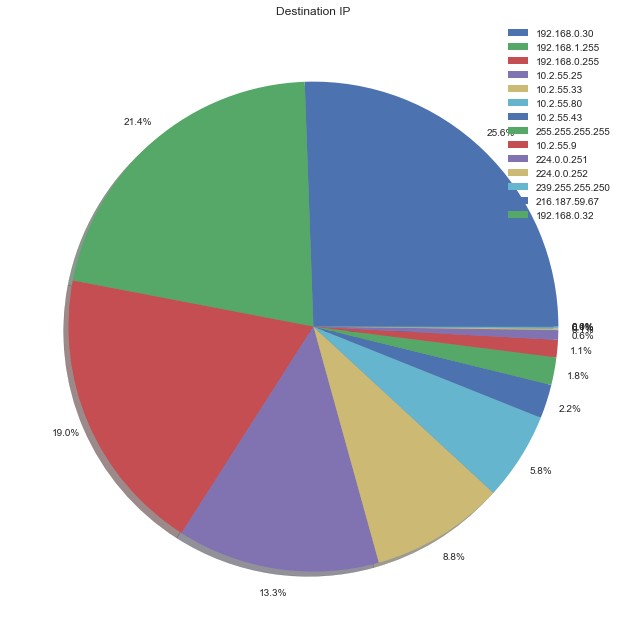

In [26]:
labels = list(tcp_udp_df['dst.1'].value_counts().keys())
fig, ax1 = plt.subplots(figsize = (20,9)) 
ax1.pie(tcp_udp_df['dst.1'].value_counts(), autopct='%.1f%%',shadow = True,pctdistance=1.1, labeldistance=1) 
plt.title("Destination IP")
ax1.legend(labels, loc = "upper right") 
plt.tight_layout() 
plt.show()

In [27]:
src_ethernet_address="01:00:5e:7f:ff:fa"

In [28]:
extract_data=tcp_udp_df[:][tcp_udp_df['src']==src_ethernet_address]

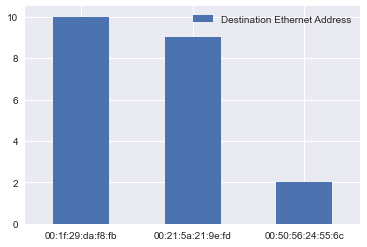

In [29]:
speed = extract_data['dst'].value_counts()
index = list(extract_data['dst'].value_counts().keys())
df = pd.DataFrame({'Destination Ethernet Address': speed}, index=index)
ax = df.plot.bar(rot=0)

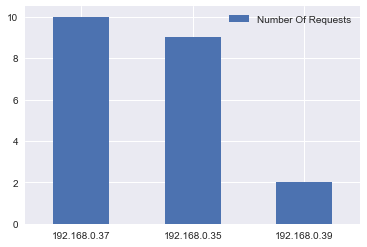

In [30]:
speed = extract_data['src.1'].value_counts()
index = list(extract_data['src.1'].value_counts().keys())
df = pd.DataFrame({'Number Of Requests': speed}, index=index)
ax = df.plot.bar(rot=0)

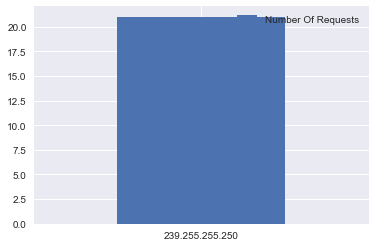

In [31]:
speed = extract_data['dst.1'].value_counts()
index = list(extract_data['dst.1'].value_counts().keys())
df = pd.DataFrame({'Number Of Requests': speed}, index=index)
ax = df.plot.bar(rot=0)

In [32]:
tcp_udp_df[['src.1','sport','dst.1','dport']]

,src.1,sport,dst.1,dport
0,192.168.0.39,55793.0,239.255.255.250,1900.0
1,192.168.0.39,137.0,192.168.0.255,137.0
2,192.168.0.39,138.0,192.168.0.255,138.0
3,192.168.0.39,137.0,192.168.0.255,137.0
4,192.168.0.39,137.0,192.168.0.255,137.0
...,...,...,...,...
22531,192.168.0.38,55024.0,192.168.0.255,137.0
22532,192.168.0.39,137.0,192.168.0.255,137.0
22533,192.168.0.39,137.0,192.168.0.255,137.0
22534,192.168.0.39,137.0,192.168.0.255,137.0


In [33]:
connections = pd.DataFrame(tcp_udp_df['src.1'].map(str)+':'+tcp_udp_df['sport'].map(str)+','+
                          tcp_udp_df['dst.1'].map(str)+':'
                          +tcp_udp_df['dport'].map(str),columns=['Conn-pair'])
unique_conn_pair = connections['Conn-pair'].value_counts()
unique_conn_pair.head(10)

192.168.1.104:137.0,192.168.1.255:137.0    4806
192.168.0.39:137.0,192.168.0.255:137.0     2149
192.168.1.104:68.0,255.255.255.255:67.0     332
10.2.55.80:80.0,192.168.0.30:1614.0         238
192.168.0.30:1614.0,10.2.55.80:80.0         187
192.168.0.37:137.0,192.168.0.255:137.0      184
192.168.0.31:137.0,192.168.0.255:137.0      168
192.168.0.38:5353.0,224.0.0.251:5353.0      144
10.2.55.33:nan,192.168.0.30:nan             123
192.168.0.30:1324.0,10.2.55.25:135.0        123
Name: Conn-pair, dtype: int64

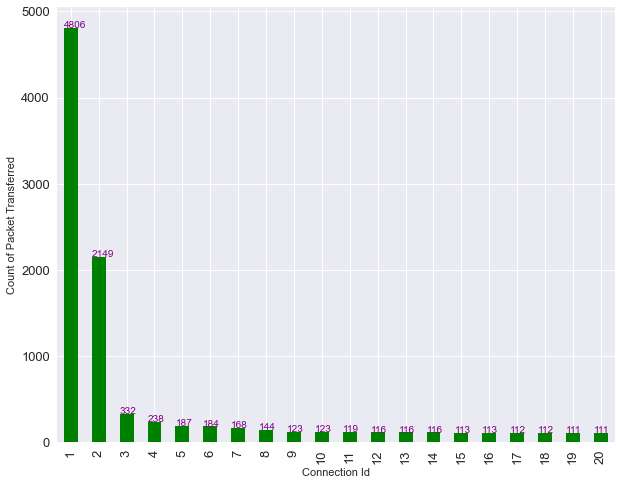

In [34]:
unique_conn = len(unique_conn_pair)
total_conn =len(connections['Conn-pair'])
unique_conn_pair.index = np.arange(1,unique_conn+1)
ax = unique_conn_pair[0:20].plot(kind='bar', figsize=(10,8),color="green", fontsize=13)
plt.xlabel('Connection Id')
plt.ylabel('Count of Packet Transferred')

for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), i.get_height(), fontsize=10,color='purple')

